In [41]:
import json
import pandas as pd
import numpy as np
from operator import itemgetter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
def load_dict_from_json(file_path):
    """
    Load content from file then parse it to dictionary

    Args:
        file_path (TYPE): Description

    Returns:
        TYPE: Description
    """
#     logger.debug('load_dict_to_json: %s', locals())
    data = {}
    with open(file_path, 'r') as file:
        text = file.read()
        temp = json.loads(text)
        data = temp
#         logger.debug('data: %s', data)

#     logger.debug('number of keys: %s', len(data))
    return data

def load_concept_definition(file_path):
    """Summary

    Args:
        file_path (TYPE): Description

    Returns:
        TYPE: Description

    No Longer Raises:
        e: Description
    """
    concepts = dict()
    data = load_dict_from_json(file_path)
    for f in data['definition']:
        conceptid = f['conceptid']
        concepts[conceptid] = dict()
        concepts[conceptid]['type'] = f['type']
        concepts[conceptid]['min_value'] = f['min_value']
        concepts[conceptid]['max_value'] = f['max_value']
        concepts[conceptid]['multiply'] = f['multiply']
        concepts[conceptid]['data'] = dict()
        for v in f['data']:
            concepts[conceptid]['data'][v['value']] = v['id']

        concepts[conceptid]['segments'] = dict()
        for s in f['segments']:
            concepts[conceptid]['segments'][s['value']] = s['id']

        concepts[conceptid]['hashmaps'] = dict()
        for h in f['hashmaps']:
            concepts[conceptid]['hashmaps'][h['value']] = h['hash']

    item2concept = dict()
    for c in data['item2concept']:
        item2concept[c['itemid']] = c['conceptid']

    return concepts, item2concept

In [7]:
# Test call shell script in Python
#!/usr/bin/python
import subprocess
def call_shell(filename):
    with open(filename, 'rb') as file:
        script = file.read()
    rc = subprocess.call(script, shell=True)

def call_shell(script):
    rc = subprocess.call(script, shell=True)


In [ ]:
# Generate QUERY_PATH
# itemids = [123456, 


# print("start")
# script = 'sleep 10\n'
# script += '../feature_transformation/feature2vec.exe print-feature-vectors %s %s %s' % (
#     MODEL_PATH, QUERY_PATH, OUTPUT_PATH)
# call_shell(script)
# print("end")

In [3]:
concepts_def, _ = load_concept_definition('../data/concept_definition.json')
# concepts_def[300003]

In [4]:
# CONSTANTS
MODEL_PATH = '../models/.bin'
OUTPUT_VEC_PATH = '../models/skipgram_ce_nm_05M.vec'

## Load vectors of features from OUTPUT_VEC_PATH


In [24]:
content = []
with open(OUTPUT_VEC_PATH) as f:
    content = f.readlines()
# remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content]

# the first line is: [number of feature] [dimension]
nb_feature, dim = content[0].split()
nb_feature = int(nb_feature)
dim = int(dim)
print('nb_feature: %s\ndim: %s' % (nb_feature, dim))

15416 100


In [25]:
content[1]

'300001,M,-0.40339 -0.014414 0.056067 -0.062775 -0.015571 0.078321 -0.10093 -0.20926 0.062862 0.19595 0.076721 -0.28638 0.17626 -0.22548 -0.03928 -0.069777 0.029668 0.1857 -0.10357 0.055029 0.32938 0.062222 -0.15437 -0.068127 -0.28701 -0.12952 -0.10464 0.1441 -0.51975 -0.097975 0.098786 0.12269 0.13232 -0.17252 0.067124 -0.074376 0.45632 0.11633 0.053786 0.0488 -0.084826 -0.1321 0.15597 0.047485 -0.029231 0.085694 0.39868 0.041081 -0.42164 0.15007 0.25926 -0.18114 -0.16843 -0.0073986 0.41324 -0.12587 0.1694 0.034031 0.099439 0.1174 0.21656 0.15165 0.086598 0.0076003 0.21487 -0.13801 0.10133 -0.0077079 0.15712 -0.57432 0.17704 0.13347 0.0046729 0.10525 0.064843 -0.30139 -0.029527 0.082778 -0.079275 -0.26226 0.36256 -0.32882 0.18171 0.15792 0.029913 -0.13356 0.38723 -0.28856 -0.092924 0.1207 -0.081743 -0.3739 -0.014985 0.12197 0.065633 -0.449 0.19282 0.054779 -0.15402 -0.25893'

In [58]:
output_feature_dict = dict()
oof_feature_dict = dict() # out of feature
for line in content[1:]:
    x = line.split(',')
    assert len(x) == 3, 'INVALID FORMAT: %s' % x
    
    conceptid = int(x[0])
    assert conceptid in concepts_def.keys(), 'conceptid=%s does not exist' % conceptid
    concept = concepts_def[conceptid]
        
    v = [float(i) for i in x[2].split()]
    assert len(v) == dim, "Dimension of vector is invalid"
    
    value = int(x[1])
    # 0 if is_number else 1
    if concept['type'] == 0:
        if value < concept['min_value']:
            value = concept['min_value'] - 1
        elif value > concept['max_value']:
            value = concept['max_value'] + 1
            
    # 
    if value not in concepts_def[conceptid]['data'].keys():
        print('cannot find index of conceptid=%s, value=%s\nLine: %s' % (
            conceptid, value, line))
        if conceptid not in oof_feature_dict.keys():
            oof_feature_dict[conceptid] = [value]
        else:
            oof_feature_dict[conceptid].append(value)
    else:
        if conceptid in output_feature_dict.keys():
            output_feature_dict[conceptid][value] = v
        else:
            output_feature_dict[conceptid] = dict()
            output_feature_dict[conceptid][value] = v

print('\nOut of features: %s' % oof_feature_dict.keys())

cannot find index of conceptid=227969, value="Quiet
Line: 227969,"Quiet,0.18962 -0.035966 -0.018773 0.2747 0.15709 -0.0069322 -0.29788 -0.36765 0.1682 0.16402 -0.13962 -0.026295 -0.29794 -0.29248 0.41446 0.16417 -0.56267 0.18738 0.16543 -0.11086 0.62077 0.38575 -0.29293 0.21644 -0.30985 -0.16966 0.020461 0.13801 -0.36737 0.50682 0.16559 -0.076241 0.28506 0.01185 -0.11781 0.19223 0.1471 -0.053753 -0.12569 -0.30585 -0.043902 -0.014663 -0.47247 -0.03256 0.16333 0.25408 0.3894 -0.10529 -0.66117 0.53059 0.23545 0.05931 0.12091 -0.17511 0.10457 -0.12203 0.15733 0.1655 0.042523 0.094749 -0.098989 0.4373 0.072139 0.28232 0.36366 0.10373 -0.09844 -0.03075 0.11441 0.32775 0.12318 -0.38407 0.32801 0.00066552 0.18489 0.079976 0.30339 -0.10741 -0.060019 -0.20166 -0.20243 0.43435 0.24214 0.051876 -0.031199 -0.56672 0.029582 0.49406 0.2007 0.048603 -0.13299 0.14757 0.20776 0.49658 0.6367 0.034291 0.34205 -0.20532 -0.57322 -0.57885
Out of features: dict_keys([227969])


### 1. Experiments with numeric features

Difference between cosine_similarity and distance
```
a = np.array([1, 0, -1]).reshape(1, -1)
b = np.array([-1,-1, 0]).reshape(1, -1)
sim = cosine_similarity(a, b)[0][0]
print(sim)
print(np.linalg.norm(a-b))

-0.4999999999999999
2.449489742783178
```

In [90]:
def calculate_distances(conceptid, output_feature_dict):
    '''
    Check distances: for example, the original values are v1=10, v2=15, v3=16, v4=20
        d(v1, v4) > d(v1, v3) > d(v1, v2)
        * d is distance function
    then their corresponding vectors must keep the original distance: 
        d(vector_1, vector_4) > d(vector_1, vector_3) > d(vector_1, vector_2)
    '''
    violate_distance = False
    
    print('Concerned concept: id=%s' % (conceptid))
    # vectors = [(value, np.array(vector).reshape(1, -1)) 
    #            for value, vector in output_feature_dict[concerned_id].iteritems()]
    vectors = [(1,[2,3]), (4,[5,6]), (7,[8,9])]
    vectors = [(value, np.array(vector).reshape(1, -1)) for value, vector in vectors]
    vectors = sorted(vectors, key=itemgetter(0), reverse=False)
    print('Sorted vectors', vectors)
    
    # calculate distance between each vector with the vector of min value
    distances = list()
    min_value, min_vector = vectors[0]
    for index, (value, vector) in enumerate(vectors):
        d = np.linalg.norm(vector - min_vector)
        distances.append(d)
        if len(distances) > 1:
            if distances[-1] < distances[-2]:
                violate_distance = True
                print('ERROR: Distance(%s, %s) is smaller than distance(%s, %s)' % (
                    min_value, value, min_value, vectors[index-1][0]))

    # extract vectors and original values
    X = np.concatenate([vector for _, vector in vectors])
    y = np.array([value for value, _ in vectors])
    print('X.shape:', X.shape)
    print('y.shape:', y.shape)
    return X, y, violate_distance, distances

In [84]:
# visualize
def plot_MDS(*data, fname=None):
    '''
    graph after MDS
    :param data: train_data, train_value
    :return: None
    '''
    D, y = data
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
    X_r = mds.fit_transform(D)

    ### graph
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    # method 1
    plt.scatter(X_r[:, 0], X_r[:, 1])
    for i, txt in enumerate(y):
        ax.annotate(txt, (X_r[i, 0] + 0.05, X_r[i, 1] + 0.05))
    
    # method 2
#     colors=((1,0,0),(0,1,0),(0,0,1),(0.5,0.5,0),(0,0.5,0.5),(0.5,0,0.5),
#         (0.4,0.6,0),(0.6,0.4,0),(0,0.6,0.4),(0.5,0.3,0.2),)
#     for label ,color in zip( np.unique(y),colors):
#         position=y==label
#         ax.scatter(X_r[position,0],X_r[position,1],label="target= {0}".format(label),color=color)
#     ax.legend(loc="best")

    ax.set_xlabel("X[0]")
    ax.set_ylabel("X[1]")
    ax.set_title("MDS")
    plt.axis('equal')
    
    if fname is not None:
        plt.savefig(fname)
    plt.show()

In [92]:
concerned_id = 300003
output_feature_dict = dict()
X, y, violate_distance, distances = calculate_distances(concerned_id, output_feature_dict)
print('Is violate?:', violate_distance)
print('distances: ', distances)

Concerned concept: id=300003
Sorted vectors [(1, array([[2, 3]])), (4, array([[5, 6]])), (7, array([[8, 9]]))]
X.shape: (3, 2)
y.shape: (3,)
Is violate?: False
distances:  [0.0, 4.242640687119285, 8.48528137423857]


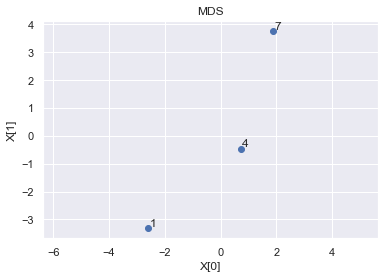

In [89]:
D = pairwise_distances(X)
plot_MDS(D, y, fname='%s.png' % concerned_id)

#### 1.1 Count number of numeric features violates distance

In [ ]:
violated_concepts = list()
for conceptid, concept in concepts_def.iteritems():
    if concept['type'] == 0:
        X, y, violate_distance, distances = calculate_distances(conceptid, output_feature_dict)
        if violate_distance:
            violated_concepts.append(conceptid)
print('Number of violated concepts: %s\nConcept ids:%s' % (len(violated_concepts), violated_concepts))

#### 1.2 Check similarity between the dublicated concepts

ONLY apply for unmerged data

### 2. Experiments with category features